## Comparing COVID surveillance systems

- This notebook describes a comparison of several different COVID surveillance systems. It approaches a widely-analyzed problem perhaps in a novel way to demonstrate data analytics and data science techniques, but also to ultimately propose an alternate surveillance system for regional governments that may be able to provide a more accurate assessment of COVID-19 infection rate status and an early indication of an emerging outbreak.

### Conventional state-level approach today

- Track the trend of positive diagnoses and the trend of the positivity rate (positive cases / total cases)
- Assuming most cases are eventually diagnosed, this is an attempt at monitoring almost the entire infected population (i.e. it doesn't rely on taking a sample of the population)
- Three clear shortcomings hinder the ability of this method to identify a regional outbreak (such as at a state level) in a timely manner

> - The signal is delayed due to the delay from the time a person with COVID becomes symptomatic (commonly thought to be 4-5 days on average), decides to get tested, and the test results find their way to the tracking system (for PCR tests can vary from 1 to several days).
> - The population monitoring mechanism isn't well-controlled. Testing includes a confusion of symptomatic people, people who have to be tested for work, people who are being tested prior to a medical procedure, people who are being tested due to exposure to someone who may have COVID, and people getting tested for other reasons. All of these test results are thrown together without control. Are the proportions of these subsets consistent over time? If not, what effect do the changes have on aggregate test results? Are test rates of asymptomatic or mildly symptomatic people consistent over time as well? Governments have issued conflicting testing guidance so it probably isn't a valid assumption to say those test rates are steady.
> - Laboratories run tests in batches. Oftentimes batches consist of samples from different days and different locations. Test numbers and positivity rates see large variances from day-to-day. 
> - The data are noisy. Std deviations of case counts for many states are almost as big as the daily mean. The size of the standard deviation means that smoothing (usually 7 days or more) must be employed to see an underlying trend.
> - Best case is a delay of only two weeks after initial infections have been spiking. It's likely to be longer.

- The charts below provide a snapshot of the challenges of using this data as a surveillance tool. 


### COVID testing data at the state level sourced from COVID Tracking Project

- Citation: [the COVID Tracking Project](https://www.covidtrackingproject.com), Creative Commons CC BY 4.0 license

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")
# covidtracking.columns

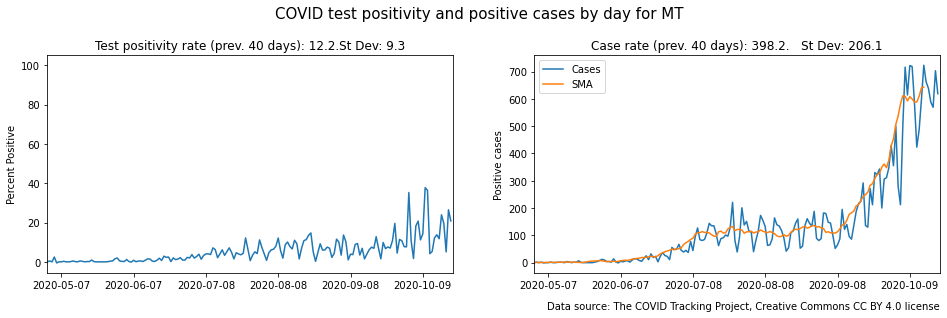

In [3]:
# Charts of positivity and case trends by state
chart_state = 'MT'

fig,ax = plt.subplots(1,2,figsize=(16,4))
fig.suptitle(f'COVID test positivity and positive cases by day for {chart_state}', size=15, y=1.05)
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

ST_cvd = covidtracking[covidtracking['state'] == chart_state]
ST_cvd['positivity'] = ST_cvd['positiveIncrease'] / (ST_cvd['positiveIncrease']  + ST_cvd['negativeIncrease'] ) * 100
ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')

ax[0].plot( ST_cvd['date'], ST_cvd['positivity'])
ax[0].set_title(f"Test positivity rate (prev. 40 days): {ST_cvd['positivity'].head(40).mean():.1f}.St Dev: {ST_cvd['positivity'].head(40).std():.1f}")
ax[0].set_xlim([datetime.date(2020, 5, 1), datetime.date.today()])
ax[0].set_ylabel('Percent Positive')
tick_spacing = 31
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


ST_cvd['case_SMA'] = ST_cvd['positiveIncrease'].rolling(window=7).mean()
ax[1].plot(ST_cvd['date'], ST_cvd['positiveIncrease'],label="Cases")
ax[1].plot(ST_cvd['date'], ST_cvd['case_SMA'], label="SMA")
ax[1].set_xlim([datetime.date(2020, 5, 1), datetime.date.today()])
ax[1].set_title(f"Case rate (prev. 40 days): {ST_cvd['positiveIncrease'].head(40).mean():.1f}.   St Dev: {ST_cvd['positiveIncrease'].head(40).std():.1f}")
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].set_ylabel('Positive cases')
ax[1].legend()
plt.show()

## Alternative random sampling systems

- Many universities across the country have developed surveillance systems that rely upon daily random sampling of their students, faculty, and staff. 
- Can a similar random sampling surveillance system work at a regional level and not just in a closed population like a university?
- Would such a system be able to detect an outbreak as it is emerging and before it reaches the rapidly acceleration exponential phase?
- Would such a system give governments and public health experts a more accurate tool for managing the pandemic in their jurisdiction?

### Calculations and assumptions for a random sampling system

- A key question is how big the daily sample needs to be to detect a meaningful change in infection rate. The calculation requires a few steps.

- 1. **Calculate COVID prevalence.** COVID prevalence (the number of people actively infected with the disease) is  low. New diagnoses of COVID from testing programs fall into the range of  15 - 100 per 100,000 people per day. A ballpark estimate of diagnosed new infections is about 0.02% of the total susceptible population. The general literature typically states that the typical COVID infection runs about 10 days, meaning that the prevalence of diagnosed COVID cases in a susceptible population is about 0.2%. This number is an under-representation of the true prevalence since some people are asymptomatic and don't know to get tested, and others who are symptomatic choose to not get tested. It is hard to pin the size of these numbers down. Estimates range wildly. A recently published metastudy estimates the percent of asymptomatic infections to be about 20% (reference). Others who have compared the presence of antibodies with the known number of cases diagnosed suggest that as many as 9 in ten COVID infections go undiagnosed (reference). For the purposes of this analysis, it is assumed that about one-third of a population's COVID infections go undiagnosed. This would imply a prevalence of 0.3%.
 - 2. **Determine which population subset to draw the sample from.** Not everyone is equally likely to be infected by COVID. A surveillance system could be designed to take advantage of the fact that COVID is mainly transmitted from person to person through respiratory droplets, which means that a person's likelihood of acquiring and obtaining COVID increases the more one has close interaction with others. While less interactive people may ultimately be infected by someone who is more interactive, the continued spread of COVID depends on those who are highly interactive. A surveillance system could be set up to monitor people who are highly interactive including those who work in front line medicine (primary care, emergency medicine, hospital-based, nursing home-based); service industry workers (restaurant employees, grocery store front end employees, bartenders, hair stylists, those who work in salons, etc.); public safety (police, fire, EMS, airport); and younger people in general. COVID prevalence is likely to be higher in this group given that people in this group have more chances for infection. (This is especially true in the early stages of an outbreak before infections have a chance to be passed on to less interactive people). ((((( Interactivity in this group is many times higher than the rest of the population. Assume 3x as likely as general population. Make more robust.))))) This would imply overall prevalence in this population subset to be about 1%.

### Version 1--Surveillance system utilizing PCR-based COVID testing

- PCR-based tests are the best tool for detecting COVID in the early stages of an infection

- A PCR-based surveillance system would be attempting to monitor active COVID infection prevalence--ideally early stage prevalence before people are likely to have sought a test. In other words, about 40% of total prevalence.
 

